GENERATING  BUTTERFLY IMAGES WITH DCGAN
  
  The DCGAN consists of two neural networks . A Generator  tries to create a realistic images and A Discriminator tries to
  distinguish between real images and fake images.

In [1]:
import cv2
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision
import shutil
import imageio
from IPython import display
from PIL import Image
from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

In [45]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [46]:
root_dir ="C:\\Users\\DELL\\Desktop\\butterfly and months"
directory="all_images"

In [47]:
# Check if the directory exists before creating it
if not os.path.exists(directory):
    os.makedirs(directory)
else:
    print(f"The directory '{directory}' already exists.")

The directory 'all_images' already exists.


TRANSFORM FUNCTION

In [48]:
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [50]:
class Butterfly(Dataset):
    def __init__(self, folder):
        super().__init__()
        self.folder = folder
        self.images = sorted(glob(folder + '/*'))
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, ix):
        image_path = self.images[ix]
        image = Image.open(image_path)
        image = transform(image)
        return image

DATA AND WEIGHTS INITIALIZATION

In [51]:
data = Butterfly(folder='all_images')
dataloader = DataLoader(data, batch_size=64, shuffle=True)

In [53]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

GENERATOR MODEL

In [54]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(100, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
        self.apply(weights_init)
    
    def forward(self, input):
        return self.model(input)

In [55]:
generator = Generator().to(device)

DISCRIMINATOR MODEL

In [56]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        self.apply(weights_init)

    def forward(self, input):
        return self.model(input)

In [57]:
discriminator = Discriminator().to(device)

LOSS AND OPTIMIZER

In [58]:
criterion = nn.BCELoss()
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [59]:
random_noise = torch.randn(64, 100, 1, 1, device=device)

In [63]:
# Define the loss function
loss = nn.BCELoss()
d_loss_s = []
g_loss_s = []

In [65]:
for epoch in range(25):
    N = len(dataloader)
    for i, images in enumerate(dataloader):
        real_data = images.to(device)
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)
        fake_data = fake_data.detach()

        discriminator_optimizer.zero_grad()
        prediction_real = discriminator(real_data)
        error_real = loss(prediction_real.squeeze(), torch.ones(len(real_data)).to(device))
        error_real.backward()
        prediction_fake = discriminator(fake_data)
        error_fake = loss(prediction_fake.squeeze(), torch.zeros(len(fake_data)).to(device))
        error_fake.backward()
        discriminator_optimizer.step()
        d_loss = error_real + error_fake
            
        fake_data = generator(torch.randn(len(real_data), 100, 1, 1).to(device)).to(device)

        generator_optimizer.zero_grad()
        prediction = discriminator(fake_data)
        g_loss = loss(prediction.squeeze(), torch.ones(len(real_data)).to(device))
        g_loss.backward()
        generator_optimizer.step()

        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f' % (epoch, 25, i, len(dataloader), d_loss, g_loss))

        d_loss_s.append(d_loss)
        g_loss_s.append(g_loss)
        if i % 95 == 0:
            fake = generator(random_noise)
            save_image(fake.data, f'butterfly/fake_epoch_{epoch:03d}.png', normalize=True)


[0/25][0/197] Loss_D: 1.5869 Loss_G: 4.3803
[0/25][1/197] Loss_D: 1.0580 Loss_G: 5.5229
[0/25][2/197] Loss_D: 1.1752 Loss_G: 4.5521
[0/25][3/197] Loss_D: 1.4792 Loss_G: 5.6839
[0/25][4/197] Loss_D: 1.4077 Loss_G: 5.5547
[0/25][5/197] Loss_D: 1.4776 Loss_G: 6.1514
[0/25][6/197] Loss_D: 1.0146 Loss_G: 7.0710
[0/25][7/197] Loss_D: 0.8693 Loss_G: 6.6858
[0/25][8/197] Loss_D: 1.1429 Loss_G: 8.6833
[0/25][9/197] Loss_D: 1.0597 Loss_G: 7.5986
[0/25][10/197] Loss_D: 1.4133 Loss_G: 9.9813
[0/25][11/197] Loss_D: 1.0825 Loss_G: 8.3850
[0/25][12/197] Loss_D: 1.3265 Loss_G: 10.8282
[0/25][13/197] Loss_D: 0.6700 Loss_G: 8.6248
[0/25][14/197] Loss_D: 1.6244 Loss_G: 12.2831
[0/25][15/197] Loss_D: 0.9590 Loss_G: 8.7156
[0/25][16/197] Loss_D: 1.0605 Loss_G: 9.9198
[0/25][17/197] Loss_D: 0.4719 Loss_G: 10.9280
[0/25][18/197] Loss_D: 0.5358 Loss_G: 8.9365
[0/25][19/197] Loss_D: 1.4022 Loss_G: 15.0437
[0/25][20/197] Loss_D: 0.7493 Loss_G: 12.6524
[0/25][21/197] Loss_D: 0.2678 Loss_G: 6.3488
[0/25][22/197] 

In [66]:
g_loss_s = [g_loss_.cpu().detach().item() for g_loss_ in g_loss_s]
d_loss_s = [d_loss_.cpu().detach() .item() for d_loss_ in d_loss_s]

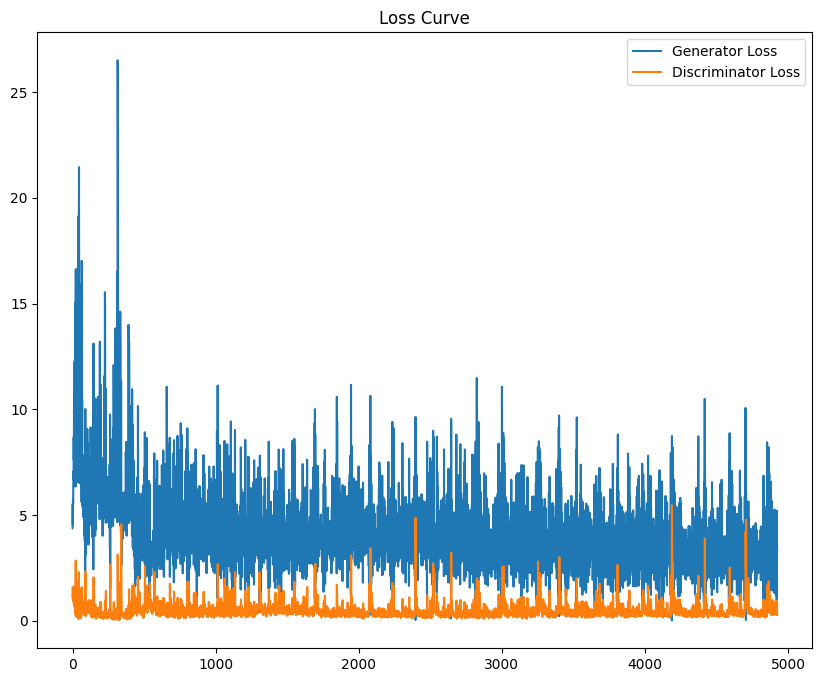

In [67]:
plt.figure(figsize=(10, 8))
plt.plot(g_loss_s) 
plt.plot(d_loss_s)
plt.title("Loss Curve")
plt.legend(["Generator Loss", "Discriminator Loss"])
plt.show()


GENERATE IMAGES

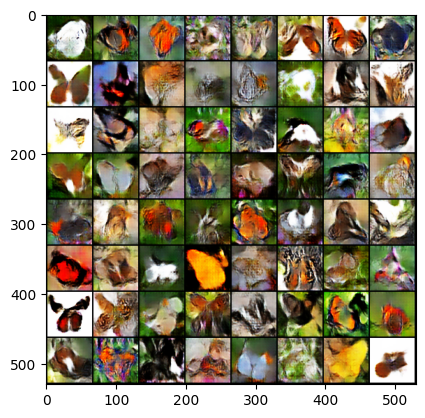

In [74]:
generator.eval()
sample_images = generator(random_noise).detach().cpu()
grid = make_grid(sample_images, nrow=8, normalize=True)
img = torchvision.transforms.ToPILImage()(grid)
plt.imshow(img)
plt.show()

In [76]:
files = glob("./butterfly/*.png")
gif_file = "./butterfly/dcgan_butterfly.gif"

In [78]:
import imageio.v2 as imageio

with imageio.get_writer(gif_file, mode='I') as writer:
    for file in files:
        image = imageio.imread(file)
        writer.append_data(image)

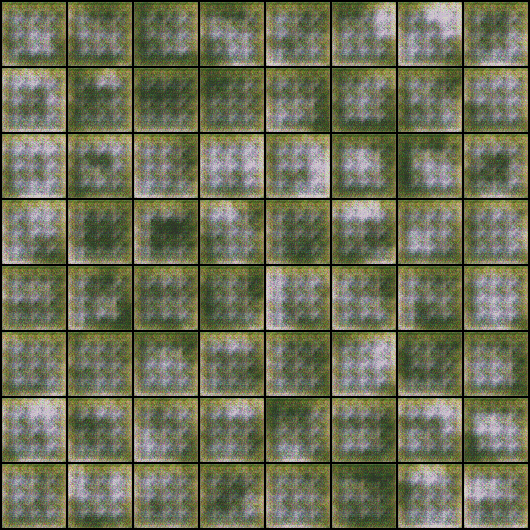

In [79]:
display.Image(filename=gif_file)